In [1]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop, Grayscale
import matplotlib.pyplot as plt
import time
import dataset as data
import model as md
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(DEVICE))

Using cpu device


In [2]:
## Hyperparameters
Batch_size = 64
Optimizer_type = 'ADAM'
Learning_rate = 1e-5
Weight_decay = 0
epochs = 100

In [3]:
def Sample_visualize(dataloader) :
  ## Visualize some preprocess images
  ##
  ## Input : dataloader of image dataset
  ## Output : image plots

 dataiter = iter(dataloader)
 images, labels = next(dataiter)
 # images = images.numpy()
 for i in range (2) :
   plt.subplot(1,4,i+1)
   plt.imshow(images[i].reshape((128, 128)), cmap='gray')
   plt.xticks([])
   plt.yticks([])
   print(labels[i])

# def visualize_dataset(dataset):
#   ## Visualize some preprocess images
#   ##
#   ## Input : DATASET of image dataset
#   ## Output : image plots
#   images, labels = dataset[0]
#   print(images.size())
#   images = images.numpy()
#   plt.imshow(images.reshape((64, 192)), cmap='gray')
#   plt.xticks([])
#   plt.yticks([])
#   print(labels)

In [4]:
transform_set = Compose([Resize((128,128)),
                Grayscale(),
                ToTensor(),
                Normalize((0.5), (0.5))])
train_data = datasets.ImageFolder(root = "./CNN_letter_dataset", transform=transform_set)
val_data = datasets.ImageFolder(root = "./CNN_letter_dataset_val", transform=transform_set)
test_data = datasets.ImageFolder(root = "./CNN_letter_dataset_test", transform=transform_set)

In [5]:
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=True)

tensor(18)
tensor(8)


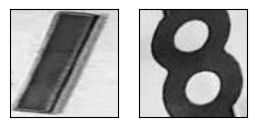

In [6]:
# visualize_dataset(full_dataset)
Sample_visualize(train_dataloader)

In [7]:
model = md.CNN(init_weights=True)
model.to(DEVICE)
print(model)

CNN(
  (localization): Sequential(
    (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=9216, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=6, bias=True)
    (16): ReLU()
  )

In [8]:
import torchsummary

torchsummary.summary(model,input_size=(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 124, 124]           1,248
       BatchNorm2d-2         [-1, 48, 124, 124]              96
              ReLU-3         [-1, 48, 124, 124]               0
         MaxPool2d-4           [-1, 48, 62, 62]               0
            Conv2d-5           [-1, 32, 58, 58]          38,432
       BatchNorm2d-6           [-1, 32, 58, 58]              64
              ReLU-7           [-1, 32, 58, 58]               0
         MaxPool2d-8           [-1, 32, 29, 29]               0
            Conv2d-9           [-1, 64, 25, 25]          51,264
      BatchNorm2d-10           [-1, 64, 25, 25]             128
             ReLU-11           [-1, 64, 25, 25]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
          Flatten-13                 [-1, 9216]               0
           Linear-14                  [

In [9]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

if Optimizer_type == 'ADAM' :
  optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)
elif Optimizer_type == 'SGD' :
  optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)

In [10]:
## Training function ##
def train(dataloader, model, loss_fn, optimizer):
  for batch_idx, (X,y) in enumerate(dataloader):

    X = X.to(DEVICE)
    y = y.to(DEVICE)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0:
      print('loss: {:.6f} [{}/{}]'.format(loss.item(), batch_idx*len(X), len(dataloader.dataset)))

In [11]:
## Validation function ##
def validation(model, valdata):
  ## Input : trained model, validation data
  ## Output : validation loss

  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in valdata:
      X, y = X.to(DEVICE), y.to(DEVICE)
      output = model(X)
      val_loss += nn.functional.cross_entropy(output, y, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
  val_loss /= len(valdata.dataset)
  print('\n***Validation Result***\nAverage loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(val_loss, correct, len(valdata.dataset), 100*correct/len(valdata.dataset)))

In [12]:
def test(model, testdata):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testdata:
      X, y = X.to(DEVICE), y.to(DEVICE)
      output = model(X)
      test_loss += nn.functional.cross_entropy(output, y, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(y.view_as(pred)).sum().item()
  test_loss /= len(testdata.dataset)
  print('\n***Test Result***\nAverage loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(test_loss, correct, len(testdata.dataset), 100*correct/len(testdata.dataset)))

In [ ]:
## Training Operation ##
start = time.time()
for t in range(epochs):
  print(f"\n[Epoch {t+1}]")
  train(train_dataloader, model, loss_fn, optimizer)
  validation(model, val_dataloader)
print("\nDone!")
end = time.time()

print("Training time: {:.4f}".format(end-start))



[Epoch 1]
loss: 3.583509 [0/28137]
loss: 3.583521 [640/28137]
loss: 3.583339 [1280/28137]
loss: 3.583195 [1920/28137]
loss: 3.582739 [2560/28137]
loss: 3.582547 [3200/28137]
loss: 3.582088 [3840/28137]
loss: 3.581458 [4480/28137]
loss: 3.579659 [5120/28137]
loss: 3.579331 [5760/28137]
loss: 3.579357 [6400/28137]
loss: 3.572129 [7040/28137]
loss: 3.568654 [7680/28137]
loss: 3.567858 [8320/28137]
loss: 3.578144 [8960/28137]
loss: 3.563140 [9600/28137]
loss: 3.569107 [10240/28137]
loss: 3.568881 [10880/28137]
loss: 3.570905 [11520/28137]
loss: 3.546273 [12160/28137]
loss: 3.557323 [12800/28137]
loss: 3.576843 [13440/28137]
loss: 3.548923 [14080/28137]
loss: 3.556778 [14720/28137]
loss: 3.537916 [15360/28137]
loss: 3.576543 [16000/28137]
loss: 3.550743 [16640/28137]
loss: 3.533314 [17280/28137]
loss: 3.555950 [17920/28137]
loss: 3.564744 [18560/28137]
loss: 3.561693 [19200/28137]
loss: 3.555916 [19840/28137]
loss: 3.521072 [20480/28137]
loss: 3.553760 [21120/28137]
loss: 3.537114 [21760/2